In [103]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [104]:

dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier_new.h5'

In [105]:
NUM_CLASSES = 24

In [106]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [107]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [108]:
print(len(X_dataset))
print(len(y_dataset))

11807
11807


In [109]:
print(y_dataset)
print(X_dataset.shape)

[ 0  0  0 ... 23 23 23]
(11807, 42)


In [110]:
train_ratio = 0.80
test_ratio = 0.20

X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=1-train_ratio, random_state=RANDOM_SEED)

In [111]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [112]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [113]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [114]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 42)                0         
                                                                 
 dense_18 (Dense)            (None, 20)                860       
                                                                 
 dropout_13 (Dropout)        (None, 20)                0         
                                                                 
 dense_19 (Dense)            (None, 10)                210       
                                                                 
 dense_20 (Dense)            (None, 24)                264       
                                                                 
Total params: 1,334
Trainable params: 1,334
Non-trainable params: 0
_________________________________________________________________


In [115]:
hist=model.fit(X_train,y_train,epochs=500,batch_size=128,validation_data=(X_test, y_test),callbacks=[cp_callback, es_callback])

Epoch 1/500
70/74 [===========================>..] - ETA: 0s - loss: 3.1754 - accuracy: 0.0483 
Epoch 00001: saving model to model/keypoint_classifier\keypoint_classifier_new.h5
74/74 [==============================] - 1s 6ms/step - loss: 3.1735 - accuracy: 0.0490 - val_loss: 3.1224 - val_accuracy: 0.0605
Epoch 2/500
58/74 [======================>.......] - ETA: 0s - loss: 3.0842 - accuracy: 0.0826
Epoch 00002: saving mod

CNN Error: 7.49%


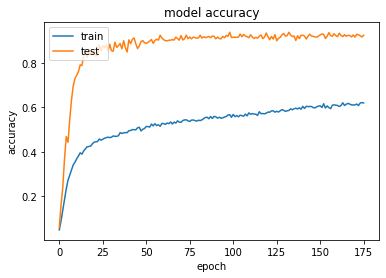

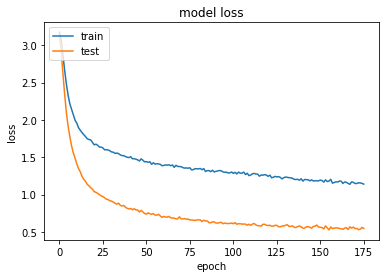

In [116]:
import matplotlib.pyplot as plt
# val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)
scores = model.evaluate(X_test,y_test, verbose=0)
print("CNN Error: %.2f%%" % (100 - scores[1] * 100))
model.save(model_save_path,include_optimizer=False)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Average prediction time: 0.000051s


Classification Report
---------------------------
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       112
           1       1.00      1.00      1.00        73
           2       0.91      0.97      0.94        99
           3       0.98      0.91      0.94        89
           4       0.89      1.00      0.94       116
           5       1.00      0.97      0.98        91
           6       1.00      0.95      0.97       101
           7       0.92      1.00      0.96       106
           8       1.00      1.00      1.00       105
           9       0.85      1.00      0.92       102
          10       1.00      1.00      1.00       111
          11       0.78      1.00      0.88        88
          12       0.90      1.00      0.95        74
          13       0.95      0.87      0.91        97
          14       0.99      1.00      1.00       100
          15       1.00      0.96      0.98     

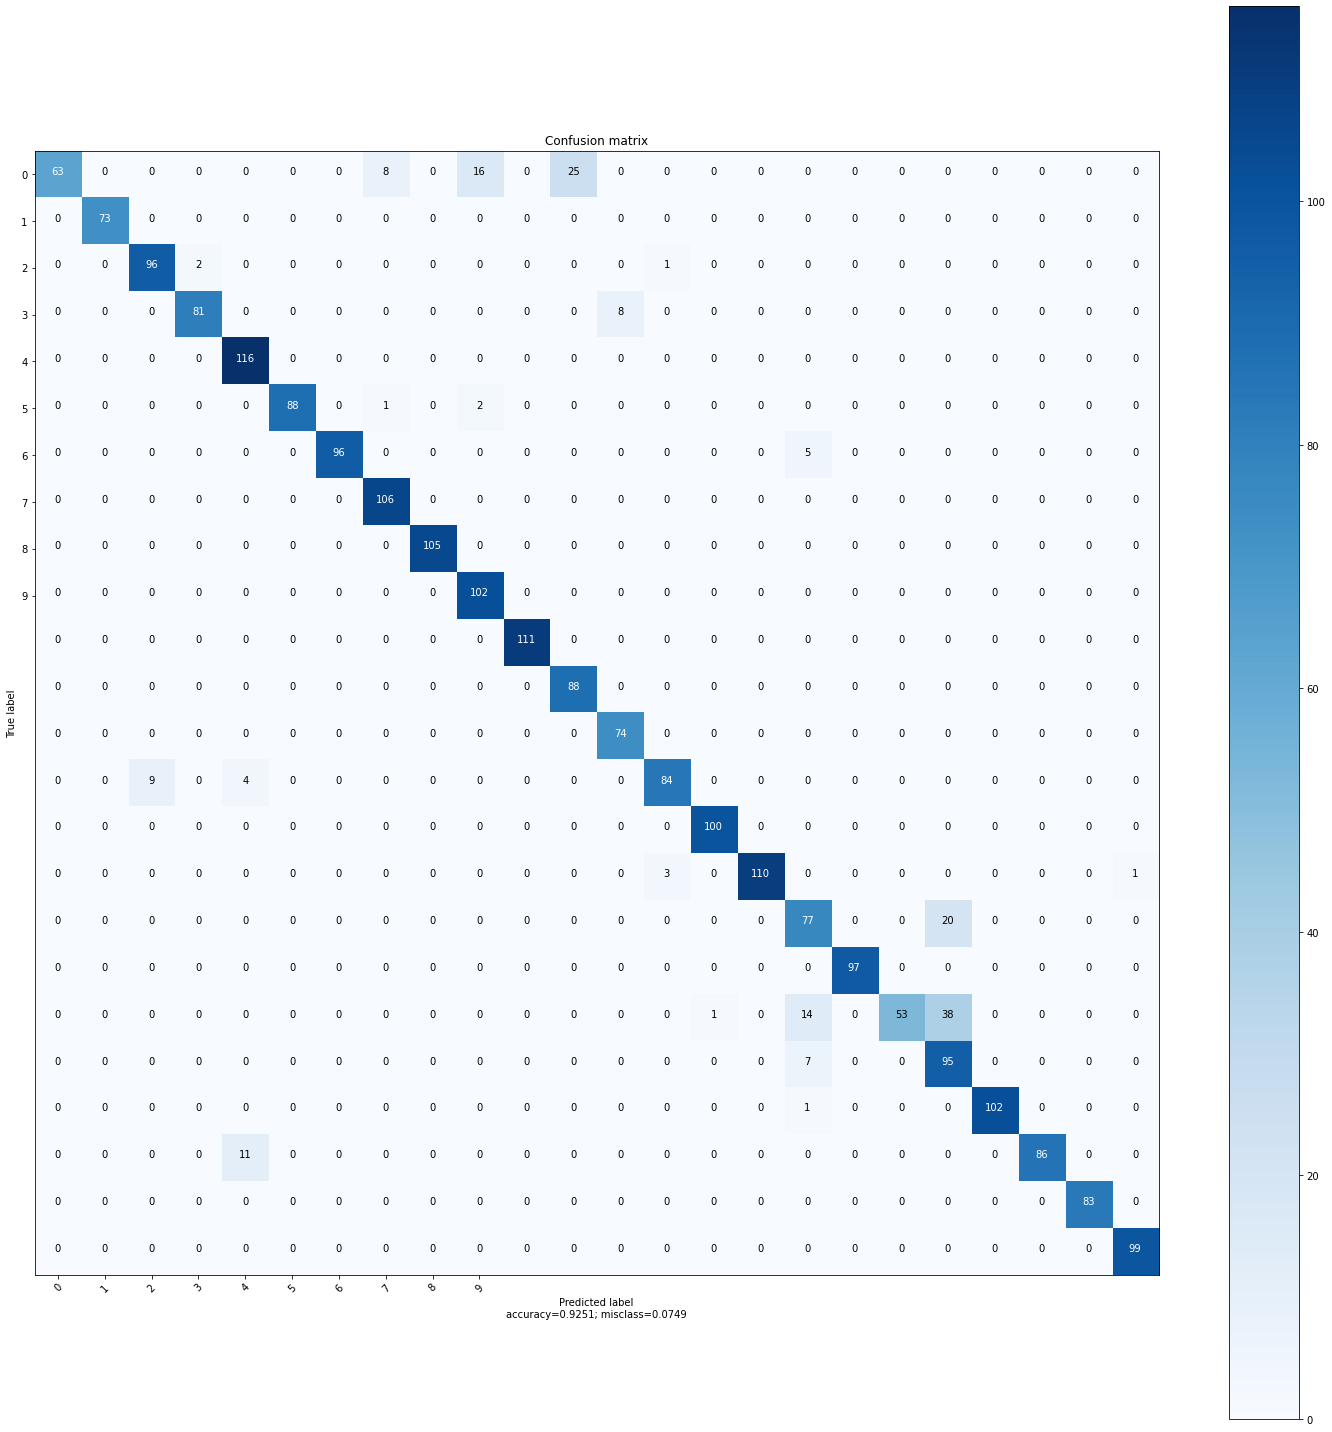

In [117]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import time
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('model/keypoint_classifier/confusion_matrix.png')


model = load_model('model/keypoint_classifier/keypoint_classifier_new.h5')
pred_labels=[]
start_time = time.time()
pred_probabs = model.predict(X_test)
end_time = time.time()
pred_time = end_time - start_time
avg_pred_time = pred_time / X_test.shape[0]
print('Average prediction time: %fs' % (avg_pred_time))

for pred_probab in pred_probabs:
    pred_labels.append(list(pred_probab).index(max(pred_probab)))

cm = confusion_matrix(y_test, np.array(pred_labels))

classification_report = classification_report(y_test, np.array(pred_labels))
print('\n\nClassification Report')
print('---------------------------')
print(classification_report)
plot_confusion_matrix(cm, range(10), normalize=False)


In [118]:
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\MSILAP~1\AppData\Local\Temp\tmpcmb6du0r\assets


INFO:tensorflow:Assets written to: C:\Users\MSILAP~1\AppData\Local\Temp\tmpcmb6du0r\assets


7344

In [119]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
